In [1]:
import sys,os
folder_name="march_madness"
BASE_DIR=os.path.abspath(".").split(folder_name)[0]+folder_name
DATA_ROOT=os.path.join(BASE_DIR,"data")
#todo setup shared utilities folder
sys.path.insert(0, DATA_ROOT)

In [2]:
import pandas as pd
pd.options.display.max_columns=999
pd.options.display.max_rows=5
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from copy import deepcopy

In [4]:
import featuretools as ft

In [6]:
seasons=pd.read_csv(DATA_ROOT+"/DataFiles/Seasons.csv").set_index("Season",drop=False)
seasons['DayZero']=pd.to_datetime(seasons['DayZero'])
regular_season_results_df=pd.read_csv(DATA_ROOT+"/DataFiles/RegularSeasonDetailedResults.csv")
regular_season_results_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [9]:
import datetime
def get_game_index(row):
    return "%s%s_%s%s"%(row['Season'],row['DayNum'],row['WTeamID'],row['LTeamID'])

def get_game_daytime(row):
    #not an acutal "day". This uses Season and DayNum without a first day to index the day_num
    
    game_day=seasons.loc[row['Season']]['DayZero']+datetime.timedelta(days=row['DayNum'])
    return game_day
    
regular_season_results_df['game_index']=regular_season_results_df.apply(get_game_index, axis=1)
regular_season_results_df['game_datetime']=pd.to_datetime(regular_season_results_df.apply(get_game_daytime, axis=1))
game=regular_season_results_df.iloc[0]
def get_team_game_log(results_df,winner=True):
    team_game_log=regular_season_results_df.copy()
    prefixes=["team_","opp_"]
    if not winner:
        prefixes=["opp_","team_"]
    rename_dict={}
    for col in regular_season_results_df.columns:
        if col=="WLoc":
            continue
        elif col.startswith("W"):
            rename_dict[col]=prefixes[0]+col[1:]
        elif col.startswith("L") and col not in ["Loc"]:
            rename_dict[col]=prefixes[1]+col[1:]
    team_game_log=team_game_log.rename(columns=rename_dict)
    return team_game_log
winner_games=get_team_game_log(regular_season_results_df, winner=True)
loser_games=get_team_game_log(regular_season_results_df, winner=False)
team_game_log=pd.concat([winner_games,loser_games],sort=False)
team_game_log=team_game_log.sort_values(by=["Season","DayNum","game_index"])
team_game_log['team_margin']=team_game_log['team_Score']-team_game_log['opp_Score']
team_game_log['team_won']=team_game_log['team_margin']>0
#teams can't tie in basketball, above code assumes that
assert(len(team_game_log[team_game_log['team_margin']==0])==0)
def get_game_loc(row):
    if row['team_won']:
        return row['WLoc']
    else:
        if row['WLoc']=='H':
            return 'A'
        elif row['WLoc']=='A':
            return 'H'
        else:
            return row['WLoc']
team_game_log['game_loc']=team_game_log.apply(get_game_loc,axis=1)
del team_game_log['WLoc']


In [10]:
team_game_log

,Season,DayNum,team_TeamID,team_Score,opp_TeamID,opp_Score,NumOT,team_FGM,team_FGA,team_FGM3,team_FGA3,team_FTM,team_FTA,team_OR,team_DR,team_Ast,team_TO,team_Stl,team_Blk,team_PF,opp_FGM,opp_FGA,opp_FGM3,opp_FGA3,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,game_index,game_datetime,team_margin,team_won,game_loc
0,2003,10,1104,68,1328,62,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,200310_11041328,2002-11-14,6,True,N
0,2003,10,1328,62,1104,68,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22,200310_11041328,2002-11-14,-6,False,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82040,2018,132,1335,68,1217,65,0,24,52,8,18,12,16,3,27,10,7,3,3,14,23,55,7,18,12,12,5,29,6,8,2,2,17,2018132_13351217,2018-03-11,3,True,N
82040,2018,132,1217,65,1335,68,0,23,55,7,18,12,12,5,29,6,8,2,2,17,24,52,8,18,12,16,3,27,10,7,3,3,14,2018132_13351217,2018-03-11,-3,False,N


In [15]:
#sort and last so we get game_loc=H when game is H. 
matchups=team_game_log.sort_values(by=["game_index","game_loc"]).groupby("game_index").last()
matchups

,Season,DayNum,team_TeamID,team_Score,opp_TeamID,opp_Score,NumOT,team_FGM,team_FGA,team_FGM3,team_FGA3,team_FTM,team_FTA,team_OR,team_DR,team_Ast,team_TO,team_Stl,team_Blk,team_PF,opp_FGM,opp_FGA,opp_FGM3,opp_FGA3,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,game_datetime,team_margin,team_won,game_loc
game_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003100_11101298,2003,100,1298,61,1110,64,0,24,48,7,15,6,12,6,26,17,18,5,1,23,22,53,10,21,10,20,11,23,15,10,6,0,18,2003-02-12,-3,False,H
2003100_11231245,2003,100,1123,83,1245,75,0,27,63,6,20,23,28,13,26,15,8,6,0,18,31,68,5,18,8,17,17,27,18,15,3,3,26,2003-02-12,8,True,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201899_14551272,2018,99,1272,65,1455,85,0,20,45,2,13,23,31,5,23,11,18,5,4,24,27,64,11,31,20,26,14,25,18,8,9,3,28,2018-02-06,-20,False,H
201899_14621139,2018,99,1139,93,1462,98,1,33,62,14,31,13,16,3,21,18,9,4,0,26,32,54,10,21,24,28,4,26,12,13,2,1,20,2018-02-06,-5,False,H


In [37]:
teams=pd.read_csv(DATA_ROOT+"/DataFiles/Teams.csv").set_index("TeamID", drop=False)

In [86]:
28*5.7

159.6

In [87]:
from collections import defaultdict
np=pd.np
def silverK(MOV, elo_diff):
    K_0=20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return K_0*multiplier,K_0*multiplier

def silverS(home_score, away_score):
    S_home,S_away=0,0
    if home_score>away_score:
        S_home=1
    elif away_score>home_score:
        S_away=1
    else:
        S_home,S_away=.5,.5
    return S_home,S_away

def silver_elo_update(team_score, opp_score, team_rating, opp_rating, game_loc):
    HOME_AD=160.
    if game_loc=='A':
        opp_rating+=HOME_AD
    elif game_loc=='H':
        team_rating+=HOME_AD
    E_team = elo_prediction(team_rating,opp_rating)
    E_opp=1-E_team
    elo_diff=team_rating-opp_rating
    MOV=team_score-opp_score
    
    S_team,S_opp = silverS(team_score,opp_score)
    if team_score>=opp_score:
        elo_winner=team_rating
        elo_loser=opp_rating
    else:
        elo_loser=team_rating
        elo_winner=opp_rating

    K_team,K_opp =  silverK(MOV,elo_winner-elo_loser)
        
    return K_team*(S_team-E_team),K_opp*(S_opp-E_opp)

def elo_prediction(home_rating,away_rating):
    E_home = 1./(1 + 10 ** ((away_rating - home_rating) / (400.)))
    return E_home

def score_prediction(home_rating,away_rating):
    return (home_rating-away_rating)/28.
class HeadToHeadModel(object):
    def __init__(self, events, update_function, prediction_function=None):
        self.update_function=update_function
        self.events=events
        self.ratings=defaultdict(lambda: 1300)
        self.prediction_function = prediction_function
        self.predictions = []
        self.curr_season=defaultdict(lambda: self.events[0][1]['Season'])

    def compute_elo_ratings(self):
        for idx, event in self.events:
            new_year=event['Season']
            label_i=event['team_TeamID']
            label_j=event['opp_TeamID']
            
            if self.curr_season[label_i]!=new_year:
                self.curr_season[label_i]=new_year
                self.ratings[label_i]=self.ratings[label_i]*.25+1505.*.75
            elif self.curr_season[label_j]!=new_year:
                self.curr_season[label_j]=new_year
                self.ratings[label_j]=self.ratings[label_j]*.75+1505.*.25
            #todo change below to just use event
            update=self.update_function(event['team_Score'],event['opp_Score'], self.ratings[label_i], self.ratings[label_j], event['game_loc'])
            self.ratings[label_i]+=update[0]
            self.ratings[label_j]+=update[1]
            

    def power_rankings(self):
        from operator import itemgetter
        #sort dictionary by value to get ascending list of teams
        power_rankings = sorted(self.ratings.items(), key=itemgetter(1), reverse=True)
        power = []
        #Make the 0-th team 1st
        for i, x in enumerate(power_rankings):
            power.append((i + 1, teams.loc[x[0]]['TeamName'],x[1]))
        return power
m=HeadToHeadModel(list(matchups[matchups['Season']<=2016].iterrows()), silver_elo_update, elo_prediction)
m.compute_elo_ratings()
m.power_rankings()

[(1, 'Gonzaga', 1781.9759428916532),
 (2, 'Kentucky', 1758.0994721820653),
 (3, 'Michigan St', 1748.4180066598908),
 (4, 'Villanova', 1742.564921662178),
 (5, 'SF Austin', 1732.543168621236),
 (6, 'Virginia', 1722.3020938154289),
 (7, 'Oregon', 1720.8865351296065),
 (8, 'Wichita St', 1719.466068472486),
 (9, 'North Carolina', 1716.9345727990828),
 (10, 'Kansas', 1716.795862568505),
 (11, 'SMU', 1702.75503567502),
 (12, 'Valparaiso', 1702.0646111859824),
 (13, 'Yale', 1695.7402880734933),
 (14, 'BYU', 1695.265321834097),
 (15, 'Stony Brook', 1690.5937675421642),
 (16, 'Arizona', 1687.6441802371526),
 (17, 'West Virginia', 1683.5635070170138),
 (18, 'Xavier', 1680.4174182922407),
 (19, "St Mary's CA", 1680.0819457481116),
 (20, 'Oklahoma', 1680.0087465097297),
 (21, 'Dayton', 1675.3606328246424),
 (22, 'Purdue', 1674.8369372685536),
 (23, 'Texas A&M', 1669.3627215871481),
 (24, 'Maryland', 1667.3695843423593),
 (25, 'S Dakota St', 1665.6470014989982),
 (26, 'Iowa', 1665.5481745847221),
 

In [88]:
#I think Elo is a good start but needs some adjustments to handle all the upsets. E.g. 2018 (marshall, virginia,Loyola, etc)
# these may be handled by a conference factor, higher K, or mean reversion

In [89]:
from itertools import combinations
tourney_seeds=pd.read_csv(DATA_ROOT+"/DataFiles/NCAATourneySeeds.csv")
possible_games_df=pd.DataFrame()
for season, seeds in tourney_seeds.groupby("Season"):
    possible_games=list(combinations(tourney_seeds[tourney_seeds['Season']==season]['TeamID'],2))
    df=pd.DataFrame(possible_games)
    df['Season']=season
    possible_games_df=possible_games_df.append(df)
possible_games_df=possible_games_df[possible_games_df['Season']>=2014]
possible_games_df['game_index']=possible_games_df.apply(lambda row: "%s_%s_%s"%(row['Season'],min([row[0],row[1]]),max([row[0],row[1]])), axis=1)

possible_games_df['TeamID']=possible_games_df.apply(lambda row: min([row[0],row[1]]),axis=1)
possible_games_df['ID']=possible_games_df.apply(lambda row: "%s_%s_%s"%(row['Season'],min([row[0],row[1]]),max([row[0],row[1]])), axis=1)

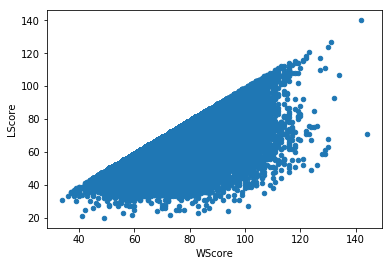

In [90]:
import matplotlib.pyplot as plt
regular_season_results_df[['WScore','LScore']].plot(kind="scatter", x="WScore",y="LScore")

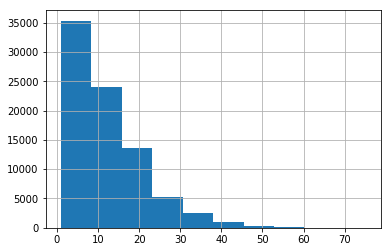

In [91]:
regular_season_results_df['winner_margin']=regular_season_results_df['WScore']-regular_season_results_df['LScore']
regular_season_results_df['winner_margin'].hist()

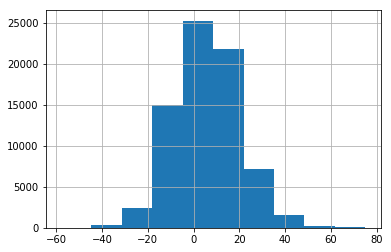

In [92]:
home_games=team_game_log[team_game_log['game_loc']=='H'].copy()
home_games['margin']=home_games['team_Score']-home_games['opp_Score']
home_games['margin'].hist()

In [93]:
home_games['margin'].describe()

count    73730.000000
mean         5.748298
             ...     
75%         14.000000
max         75.000000
Name: margin, Length: 8, dtype: float64

5.74 point home ad

In [94]:
possible_games_df

,0,1,Season,game_index,TeamID,ID
0,1438,1437,2014,2014_1437_1438,1437,2014_1437_1438
1,1438,1235,2014,2014_1235_1438,1235,2014_1235_1438
...,...,...,...,...,...,...
2276,1252,1411,2018,2018_1252_1411,1252,2018_1252_1411
2277,1300,1411,2018,2018_1300_1411,1300,2018_1300_1411


In [95]:
models={}
for season in range(2014,2018+1):
    print(season)
    m=HeadToHeadModel(list(matchups[matchups['Season']<=season].iterrows()), silver_elo_update, elo_prediction)
    m.compute_elo_ratings()
    m.power_rankings()
    models[season]=m

2014
2015
2016
2017
2018


In [133]:
def get_elo_probability(row):
    m=models[row['Season']]
    team1,team2=sorted([row[0],row[1]])
    return elo_prediction(m.ratings[team1],m.ratings[team2])
possible_games_df['elo_win_probability']=possible_games_df.apply(get_elo_probability, axis=1)
possible_games_df['elo_win']=possible_games_df['elo_win_probability'].apply(lambda x: 1 if x>=.5 else 0)
possible_games_df['Pred']=possible_games_df['elo_win_probability']#np.clip(possible_games_df['elo_win_probability'],.3,.7)

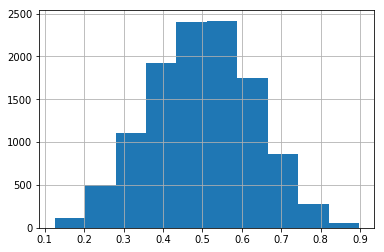

In [134]:
possible_games_df['Pred'].hist()

In [135]:
tourney_results=pd.read_csv(DATA_ROOT+"/DataFiles/NCAATourneyCompactResults.csv")
for col in tourney_results.columns:
    if "ID" in col:
        tourney_results[col]=tourney_results[col].astype(str)
tourney_results['game_index']=tourney_results.apply(lambda row: "%s_%s_%s"%(row['Season'],min([row["WTeamID"],row["LTeamID"]]),max([row["WTeamID"],row["LTeamID"]])), axis=1)
tourney_results['lower_id_wins']=tourney_results.apply(lambda row: 1 if row['WTeamID']==row['game_index'].split("_")[1] else 0, axis=1)

In [136]:
len(tourney_results)

2184

In [137]:
predictions=tourney_results.merge(possible_games_df,on="game_index",how="left",suffixes=["","_y"])

In [138]:
predictions

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,game_index,lower_id_wins,0,1,Season_y,TeamID,ID,elo_win_probability,Pred,elo_win
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,2018,152,1437,95,1242,79,N,0,2018_1242_1437,0,1437.0,1242.0,2018.0,1242.0,2018_1242_1437,0.367445,0.367445,0.0
2183,2018,154,1437,79,1276,62,N,0,2018_1276_1437,0,1437.0,1276.0,2018.0,1276.0,2018_1276_1437,0.278881,0.278881,0.0


In [139]:
from sklearn.metrics import log_loss
log_loss(predictions[predictions['Season']>=2014]['lower_id_wins'],predictions[predictions['Season']>=2014]['elo_win_probability'])

0.6176410803025985

In [140]:
from sklearn.metrics import accuracy_score

In [141]:
accuracy_score(predictions[predictions['Season']>=2014]['lower_id_wins'],predictions[predictions['Season']>=2014]['elo_win'])

0.6597014925373135

In [128]:
possible_games_df[['ID','Pred']].to_csv("elo_model_no_tuning.csv",index=False)